In [3]:
#     A) plot the SIR vs time for the seed being highest degree
#     B) plot SIR vs time for  random
#     C) propose and implement your own mitigation technique, how effective was your mitigation strategy on the targeted attack? ()
# 
import networkx as nx 
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import operator
import time
import random
DELTA_RECOVER = 7
DELTA_INFECT = 5
p_transmit_virus = .015
SEED = .04
infected = set()

In [17]:
# #converts a list of tuples into dictionary (use this for G.degrees() if you want)
# def convert_tuple_to_dict(list_of_tuples):
#     my_dict = dict()
#     for i,j in list_of_tuples:
#         my_dict[i] = j
#     return my_dict


#build scale free networks
def build_networks(days, N):
    networks = list()
    for i in range(days):
        # seed = int(SEED * N)
        # G = nx.barabasi_albert_graph(N,seed)
        G = nx.read_gexf(f"./Graphs/{i+1}.gexf")
        networks.append(G)
    return networks

In [59]:
def init_population(mode,N, m, networks):
    
    #initialize a population of n nodes 
    G = networks[0]
    #depending on which mode, choose m patient 0's 
    for person in G.nodes:
        if G.nodes[person]['political_label'] == 'Conservative' or G.nodes[person]['political_label'] == 'Liberal':
            infected.add(person)

    # if mode == 'top_degree':
    #     # choose 5 nodes with the highest degree from networks[0]
    #     infected = [x[0] for x in sorted(G.degree, key=lambda x: x[1], reverse=True)[:DELTA_INFECT]]
    # elif mode == 'random':
    #     #choose 5 nodes at random
    #     infected = random.sample(range(0, N-1), DELTA_INFECT)
    
    for person in G.nodes:
        if G.nodes[person]['political_label'] == 'Conservative' or G.nodes[person]['political_label'] == 'Liberal':
            G.nodes[person]['status'] = 'infected'
            #G.nodes[person]['time'] = DELTA_RECOVER
        else:
            G.nodes[person]['status'] = ''
            #G.nodes[person]['time'] = -1          
    
    return infected

In [48]:
#Susceptible-Infected-recovered simulation 
def run_experiment(days,networks,infected, mitigation_mode, label):
    for day in range(days):
        #print(f"Day {day}")
        new_infected = set()
        G = networks[day]
        #susceptible to infected
        # if day != (days-1):
        #     for person in G.nodes:
        #         networks[day+1].nodes[person]['status'] = G.nodes[person]['status']
        #         networks[day+1].nodes[person]['time'] = G.nodes[person]['time']
        # for person in G.nodes:
        #     if G.nodes[person]['time'] == day and day != (days-1):
        #         infected.remove(person)
        #         networks[day+1].nodes[person]['status'] = 'recovered'
        #         networks[day+1].nodes[person]['time'] = 0
        #     elif day!= (days-1):
        #         networks[day+1].nodes[person]['status'] = G.nodes[person]['status']
        #         networks[day+1].nodes[person]['time'] = G.nodes[person]['time']

        for person in infected:
            if person in G.nodes:
            #get neighbors  
             
            # if mitigation_mode == 1:
            #     middle = len(neighbors)//2
            #     neighbors = list(G.neighbors(person))[:middle]
            # else:
                neighbors = list(G.neighbors(person)) 
                
                for neighbor in neighbors:
                    pass
                    if random.random() <= G.nodes[person][f'{label}_politicalness'] and day != (days-1):
                        new_infected.add(neighbor)
                        try:
                            networks[day+1].nodes[neighbor]['status'] = 'infected'
                        except KeyError:
                            pass
                        #networks[day+1].nodes[neighbor]['time'] = day + DELTA_RECOVER
            #infected to recovered 
        
        infected.update(new_infected)

          
    return 



In [51]:
def plot_SIR(networks,days):
    plt.figure()
    plt.plot([x for x in range(days-1)], [len([y[0] for y in networks[x].nodes.data() if y[1]['status'] == 'infected']) for x in range(days-1)], label='infected')
    #plt.plot([x for x in range(days-1)], [len([y[0] for y in networks[x].nodes.data() if y[1]['status'] == 'susceptible']) for x in range(days-1)], label='susceptible')
    #plt.plot([x for x in range(days-1)], [len([y[0] for y in networks[x].nodes.data() if y[1]['status'] == 'recovered']) for x in range(days-1)], label='recovered')
    #plot infection vs day from part A 

    #plot infection vs day from part B

    #plot infection vs day from part C 

    #label your plot lines 
    plt.legend()
    plt.grid()
    plt.title("Number of Infections vs Day")
    plt.xlabel("Day")
    plt.ylabel("Number of infections")
    plt.show()
    #or plt.savefig(fname) to save your figure to a file 

    #screenshot this figure and place in your HW2 PDF. 

    
    return 

In [22]:
def average_pol(G, n, label):
    pols = []
    for _, _, data in G.out_edges(n, data=True):
        pols.append(data[f'avg_{label}_pol'])
    return np.average(pols) if pols else 0

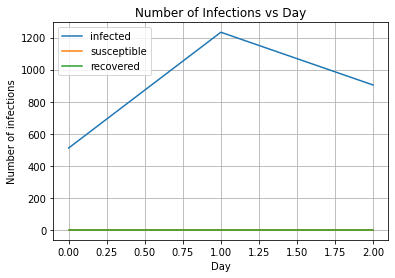

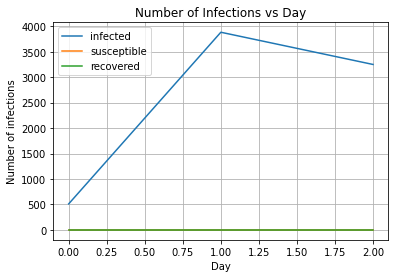

In [62]:
def main():
    
    #init experiment based on 
    days = 4
    N = 1
    m = 1 
    networks = build_networks(days,N)
    for network in networks:
        for person in network:
            network.nodes[person]['status'] = ''
            network.nodes[person]['conservative_politicalness'] = average_pol(networks[0], person,'Conservative')*1000
            network.nodes[person]['liberal_politicalness'] = average_pol(networks[0], person,'Liberal')*1000
    
    #initialize population for top 5 degrees 
    infected = init_population("top_degree", N, m, networks)


    

    # print(networks[0].nodes['Bigron808'])
    # print(networks[0].nodes['Adelaidey'])
    # print(networks[0].nodes['zalecot'])
    #run SIR experiment A
    run_experiment(days,networks, infected, 0, 'conservative')
    plot_SIR(networks,days)

    networks = build_networks(days,N)
    for network in networks:
        for person in network:
            network.nodes[person]['status'] = ''
            network.nodes[person]['conservative_politicalness'] = average_pol(networks[0], person,'Conservative')*1000
            network.nodes[person]['liberal_politicalness'] = average_pol(networks[0], person,'Liberal')*1000

    infected = init_population("top_degree", N, m, networks)
    run_experiment(days,networks, infected, 0, 'liberal')
    plot_SIR(networks,days)
   
    # #initialize population for random 5 nodes 
    # infected = init_population("random", N, m, networks)
    # # #run SIR experiment B 
    # run_experiment(days,networks, infected, 0)
    # plot_SIR(networks)


    # # #implement your own mitigation strategy (part C)
    # #initialize population for top 5 degrees 
    # infected = init_population("top_degree", N, m, networks)
    # #run SIR experiment A
    # run_experiment(days,networks, infected, 1)
    # plot_SIR(networks)
   
    # #initialize population for random 5 nodes 
    # infected = init_population("random", N, m, networks)
    # # #run SIR experiment B 
    # run_experiment(days,networks, infected, 1)
    # plot_SIR(networks)

    # # #plot all infections vs time 





if __name__ == '__main__':
    main()


In [24]:
infected

{'294261',
 '2times21',
 'AFailedExperiment',
 'Adelaidey',
 'AdvocateForLucifer',
 'AliasUndercover',
 'Allisonaxe',
 'AlmostAlwaysThinking',
 'ApocalypseWoodsman',
 'ArchieBunkerWasRight',
 'AreaAtheist',
 'Arx0s',
 'Aspro1890',
 'Atario',
 'AuH2O_Conservative',
 'BOSS_OF_THE_INTERNET',
 'Backwatermutant32',
 'Bad_Advice_Cat',
 'BagOnuts',
 'BananaSlice',
 'BaseActionBastard',
 'BasedTebow',
 'BigClifty',
 'Bigron808',
 'Blue_Train',
 'Bookwormy13',
 'BowsNToes21',
 'Burninator01',
 'Cadaverlanche',
 'CaptOblivious',
 'CarolinaPunk',
 'CavScout88',
 'Center60',
 'Cern_Stormrunner',
 'CharredOldOakCask',
 'Chinstrap6',
 'ChrisHernandez',
 'ChuckYeah',
 'Coffeegorilla',
 'CommonFound',
 'CosmicPube',
 'DDRExtremist247',
 'DNAbro',
 'DasGoon',
 'Deathduck',
 'Deimos56',
 'DiamondBack',
 'Dietmeister',
 'Dinosaur_Boner',
 'DiscordianStooge',
 'Dom19',
 'DonnieS1',
 'DorkJedi',
 'Dranosh',
 'DreamOfTheRood',
 'DumpyLips',
 'Duncanconstruction',
 'Dustonthepaladin',
 'EngineerDave',
 'Enig